# Retrasos en Reportes COVID19 de Mininsterio de Salud Argentina

#### Autor: Mariano Crosetti (@mcros22)
##### Agradecimiento a Mauro Infantino (@plenque) cuya recolección de reportes (https://covidstats.com.ar/archivos/) hizo posible este análisis

## Resumen

Analizamos cuantitativamente el retraso que existe en los reportes de diagnósticos Datos Abiertos de Ministerio de Salud (http://datos.salud.gob.ar/dataset/covid-19-casos-registrados-en-la-republica-argentina).

Constatamos que los reportes en las planillas de datos abiertos coinciden con los reportes oficiales dado por canales como twitter (https://twitter.com/msalnacion).

Arrojamos luz acerca del *significado* (cómo deben ser interpretados acorde a estas demoras) de los datos. Creemos que esto puede servir tanto a:
- analistas que se basan en los datos abiertos para hacer gráficas.
- periodistas que hacen notas y reportes con los datos publicados por @msalnacion.
Un análisis o notas periodísticas serias deben tener necesariamente en cuenta esta situación.

Además el presente reporte libera el código con el que se hizo el análisis, constituyendo un experimento *reproducible y auditable* para otros analistas. Pude también ser usado fácilmente para analizar demoras en otros eventos reportados (como por ejemplo internaciones).

Por otro lado pretende hacer un aporte también a los agentes tomadores de decisión pudiendo señalar en que regiones se producen las mayores demoras.

## Desarrollo del trabajo

Diariamente el Ministerio de Salud de la Nación Argentina emite dos informes diarios con nuevos diagnósticos, fallecimientos y otros eventos relacionados a la pandemia de COVID19 en el territorio Argentino.

Además y de hace 15/05 se publican datos abiertos desagregados por casos en http://datos.salud.gob.ar/dataset/covid-19-casos-registrados-en-la-republica-argentina. Publicar datos abiertos es un paso de enorme transparencia y permite la realización de análisis y aportes privados (como el presente).

Muchos de los que analizamos y visualizamos la evolución de los contagios, fallecimientos (y otros eventos como internaciones, uso de respiradores, etc) utilizando los datos abirtos, ya sabemos que existen demoras en la carga de esos eventos. O sea, que en el reporte de un día se reportan diagnósticos, fallecimientos, internaciones de fechas varios días anteriores. Es por eso que muchos optan por no mostrar los valores de los últimos días (como hacemos en https://covidargentina.com.ar/?sec=G) o señalarlos en otro color e indicar que son valores que siguen creciendo (https://twitter.com/mmbarrionuevo/status/1282094493735497729).

Otros, especialmente muchos periodistas analizan de primera mano la información proveída por MinSalud (https://twitter.com/msalnacion). Veremos que los reportes en datos abiertos están tan actualizados como los reportes de sitaución de twitter (por lo cual deducimos que en éstos últimos los contagios, fallecimientos, etc informados respectan a varios días antes). Es por eso que es importante para quién se base o difunda la información de @msalnacion conocer de estas demoras.

El tema de rezasgos en los datos informados se viralizó la semana pasada en los tweets: https://twitter.com/fedetiberti/status/1291803901558247433 y nota de La Nación https://www.lanacion.com.ar/sociedad/coronavirus-uno-cada-cinco-muertes-pais-fueron-nid2415945.
Por un lado la viralización es positiva en el sentido que es correcto que todo aquel que lea, y en especial difunda o visualice datos *debiera* conocer del rezasgo y entender su cuantificación. Por el otro de no ser informada bien sólo ayuda a descreer de cualquier tipo de información oficial lo cuál termina siendo **peligroso**.

In [4]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [84]:
from common import *

## Preliminar

Para hacer este análisis necesitamos contar con los reportes diarios de TODOS los días (para compararlos y ver cuándo aparecen reportados los eventos por primera vez). Afortunadamente Mauro Infantino (https://twitter.com/plenque) se encargó de ello en https://covidstats.com.ar/archivos/.

Usar las funciones *download_all_csvs()* y *extract_all_tar()* para descargar en *DATA_PATH* los reportes y extraerlos respectivamente.

*Advertencia:*los targz por sí solo ocupan 500 MB y los csv's descomprimidos 10 GB.

## Analizando todos los reportes

A continuación analizamos todos los csv's, filtrando los que clasificacion_resumen==Confirmado y agrupando por fecha_diagnostico (por ahora todos juntos, luego haremos para cada provincia). 
El csv obtenido tiene para cada fecha_diagnostico cuánto fue reportado en cada csv (columna value). Esta función suele demorar por lo cual subí fecha_diagnostico.csv al repo.

In [6]:
history_df = create_history_df(csv_oldest_date='2019',
                               analysed_date_column = 'fecha_diagnostico',
                               locations_columns_hierarchy = [],
                               filter_function = filter_confirmados,
                               verbose=False)
history_df.to_csv('./fecha_diagnostico.csv',index=False)
history_df

/home/marian/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/marian/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,LOCATION,fecha_diagnostico,value,fecha_csv
0,ALL,2020-03-03,1,2020-06-16
1,ALL,2020-03-06,6,2020-06-16
2,ALL,2020-03-07,1,2020-06-16
3,ALL,2020-03-08,2,2020-06-16
4,ALL,2020-03-09,6,2020-06-16
...,...,...,...,...
7042,ALL,2020-08-04,6413,2020-08-08
7043,ALL,2020-08-05,6860,2020-08-08
7044,ALL,2020-08-06,6184,2020-08-08
7045,ALL,2020-08-07,5355,2020-08-08


## Comparando contra twitter 

Antes de analizar las demoras en los datos abiertos obtendremos la diferencia diaria de diagnósticos reportados para algunas fechas y lo compararemos con lo reportado por la cuenta de twitter de 

El código que se encuentra a continuación muestra las diferencias reportadas en diagnósticos diarios. Copiamos aquí los reportas sacados de los cortes diarios de https://twitter.com/msalnacion (los casos nuevos diarios aparecen en varios tweets a lo largo del día y luego hacen un corte y aparece el número del día siguiente).

2020-08-01 5929
2020-08-02 5241
2020-08-03 5376
2020-08-04 4824 
2020-08-05 6792

Vemos que los números no difieren mucho. Salvo el 08-04 y 08-05 (pero si los sumamos dan lo mismo). Probablemnte hayan hecho un corte distinto entre los datos abiertos y el reporte ese día. Pero lo que nos indica este análisis es que se trata de la misma información y que los retrasos que analicemos en los datos abiertos también existen en los datos anunciados en @msalnacion (y por ende los que ponen en las noticias diarios y programas de televisión).

In [17]:
history_df.groupby('fecha_csv')['value'].sum().diff().loc[['2020-08-01','2020-08-02','2020-08-03','2020-08-04','2020-08-05']]

fecha_csv
2020-08-01     5241.0
2020-08-02     5372.0
2020-08-03     4828.0
2020-08-04    10022.0
2020-08-05     3917.0
Name: value, dtype: float64

## Analizando retraso

El código que tenemos a continuación calcula las variaciones diarias reporadas en diferentes días y para cada una el delay en días que tardaron esos casos en reportarse para determinada fecha_diagnostico

In [10]:
hdf = pd.read_csv('fecha_diagnostico.csv')

analysed_date_column = [c for c in history_df.columns if c not in ['LOCATION', 'fecha_csv', 'value']][0]

hdf = format_history_df(hdf, analysed_date_column)
hdf.set_index(['LOCATION','fecha_diagnostico','fecha_csv']).sort_index()

value  value_diff  delay  \
LOCATION fecha_diagnostico fecha_csv                              
ALL      2020-06-16        2020-06-16    513       513.0      0   
                           2020-06-17   1229       716.0      1   
                           2020-06-18   1517       288.0      2   
                           2020-06-19   1586        69.0      3   
                           2020-06-20   1599        13.0      4   
...                                      ...         ...    ...   
         2020-08-06        2020-08-07   5560      3116.0      1   
                           2020-08-08   6184       624.0      2   
         2020-08-07        2020-08-07   2435      2435.0      0   
                           2020-08-08   5355      2920.0      1   
         2020-08-08        2020-08-08   1783      1783.0      0   

                                       weighted_delay  value_ratio  
LOCATION fecha_diagnostico fecha_csv                                
ALL      2020-06-16        2020-06-16             0.0     0.309222  
                           2020-06-17           716.0     0.740808  
                           2020-06-18           576.0     0.914406  
                           2020-06-19           207.0     0.955998  
                           2020-06-20            52.0     0.963834  
...                                               ...          ...  
         2020-08-06        2020-08-07          3116.0     0.899094  
                           2020-08-08          1248.0     1.000000  
         2020-08-07        2020-08-07             0.0     0.454715  
                           2020-08-08          2920.0     1.000000  
         2020-08-08        2020-08-08             0.0     1.000000  

[1484 rows x 5 columns]

Con esta información se puede extraer para cada fecha_diagnostico métricas acerca de su retraso. A continuación vemos el promedio de retraso que tenemos *actualmente* para cada fecha_diagnostico.

Notar que nos referimos a *actualmente* porque sobre los últimos días es probable que en los futuros reportes sean reportados casos con fechas_diagnosticos para esos días por lo cual el retraso promedio de esos días todavía es suceptible de seguir creciendo.

In [27]:
expected_delay(hdf,analysed_date_column).iloc[-30:-7]

expected_delay
LOCATION fecha_diagnostico                
ALL      2020-07-10               1.587823
         2020-07-11               1.821985
         2020-07-12               1.427035
         2020-07-13               1.459095
         2020-07-14               1.699181
         2020-07-15               1.569508
         2020-07-16               1.832780
         2020-07-17               1.963559
         2020-07-18               2.227987
         2020-07-19               1.562890
         2020-07-20               1.715105
         2020-07-21               1.541652
         2020-07-22               1.523942
         2020-07-23               1.389015
         2020-07-24               1.512690
         2020-07-25               1.352828
         2020-07-26               1.472389
         2020-07-27               1.296533
         2020-07-28               1.510120
         2020-07-29               1.425182
         2020-07-30               1.208362
         2020-07-31               1.383456
         2020-08-01               1.233400

Si bien se calculo el retraso promedio para mostrar lo que podíamos hacer con los datos no creemos recomendable fijarnos en esta medida a la hora de analizar *estos* datos.

Esto es debido a que la distribución es claramente no normal y no nos dice mucho la media, ni la varianza, ya que son indicadores no robustos (un outliers suficientemente grande puede aumentar la media y varianza arbitrariamente). A continuación mostramos una gráfica de los valores de value_diff para ciertas fechas_diagnosticos en función al delay para observar las distribuciones.

fecha_diagnostico,2020-07-20,2020-07-21,2020-07-22,2020-07-23,2020-07-24,2020-07-25,2020-07-26,2020-07-27,2020-07-28,2020-07-29,2020-07-30,2020-07-31
delay,,,,,,,,,,,,
0,637.0,1659.0,1760.0,2025.0,2016.0,1464.0,1011.0,1602.0,1973.0,1898.0,1926.0,2022.0
1,2777.0,2685.0,2544.0,2267.0,2326.0,2000.0,1381.0,2463.0,2302.0,3002.0,2713.0,2444.0
2,536.0,600.0,698.0,455.0,616.0,485.0,432.0,441.0,634.0,387.0,562.0,1335.0
3,229.0,149.0,206.0,303.0,399.0,352.0,218.0,145.0,213.0,150.0,211.0,349.0
4,135.0,63.0,52.0,224.0,240.0,145.0,83.0,241.0,88.0,179.0,187.0,377.0
5,111.0,42.0,67.0,187.0,123.0,29.0,17.0,78.0,51.0,128.0,122.0,23.0
6,43.0,54.0,176.0,73.0,178.0,69.0,43.0,36.0,232.0,198.0,66.0,57.0
7,46.0,124.0,49.0,93.0,89.0,48.0,4.0,11.0,193.0,68.0,67.0,64.0
8,17.0,79.0,91.0,61.0,27.0,35.0,20.0,99.0,85.0,91.0,40.0,99.0


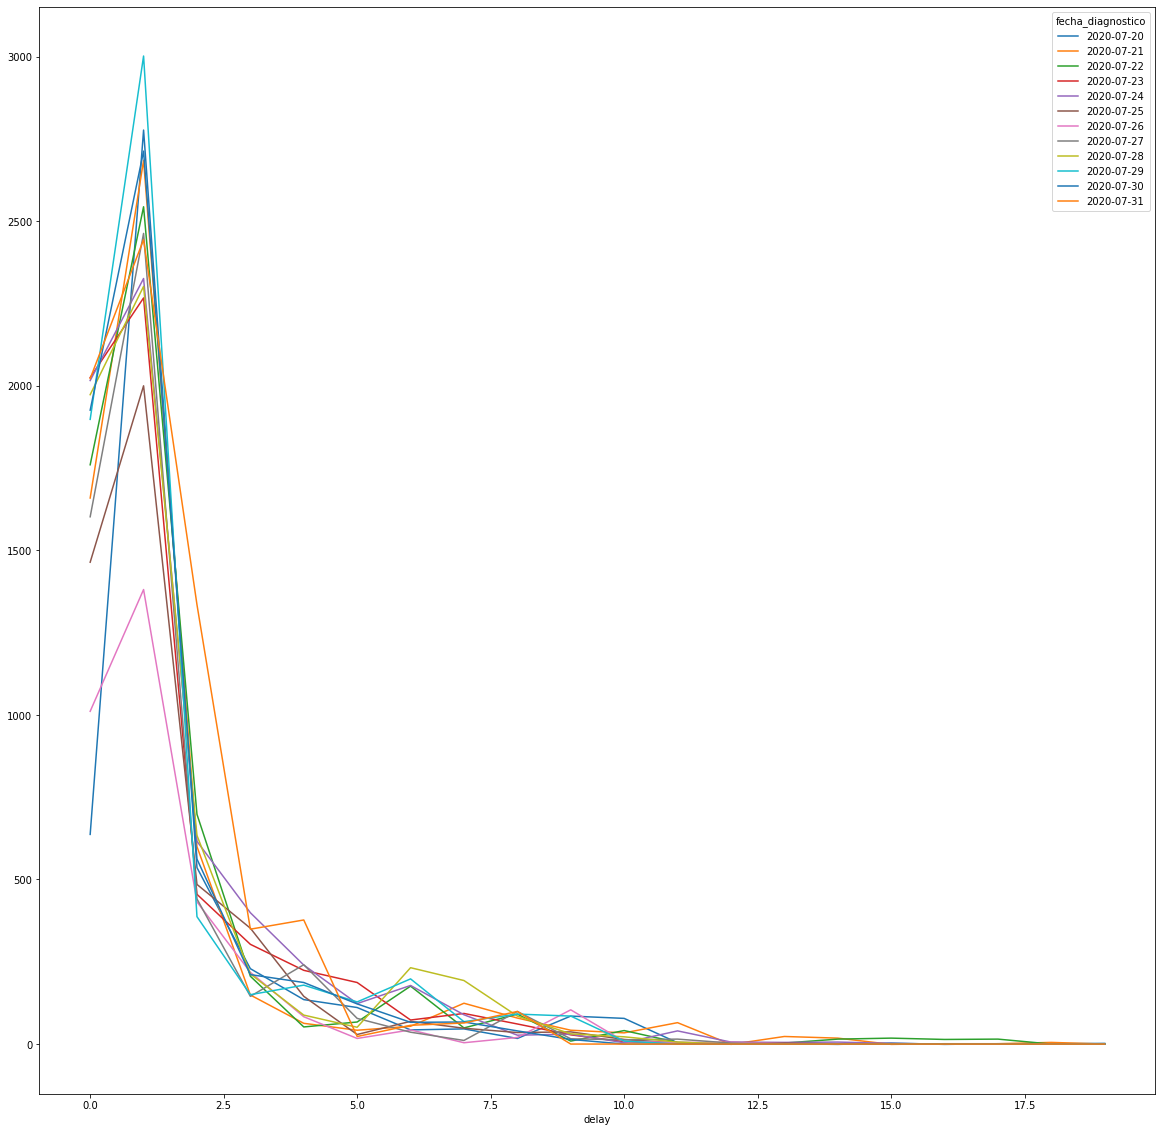

In [36]:
hdf_toplot = hdf[(hdf['fecha_diagnostico']>='2020-07-20') & (hdf['fecha_diagnostico']<'2020-08-01')]
plot_df = hdf_toplot.pivot(index='delay', columns='fecha_diagnostico', values='value_diff')
display(plot_df)
plot_df.fillna(0).plot(figsize=(20,20))

### Medidas robustas

Una medida más significativa y robusta podría ser la mediana (sabemos que el 50% de los eventos reportados fueron reportados antes de cierto número de días). U otra medida del estilo como los cuartiles o percentiles. Actualmente tomamos el percentil 90: sabemos que se han reportado el 90% de los casos con hasta cierta cantidad de días de retraso. A continuación para cada fecha_diagnóstico:

In [56]:
delay_to_confident(hdf,'fecha_diagnostico',0.90).set_index(['LOCATION','fecha_diagnostico']).sort_index()

fecha_csv  delay
LOCATION fecha_diagnostico                   
ALL      2020-06-16         2020-06-18      2
         2020-06-17         2020-06-20      3
         2020-06-18         2020-06-22      4
         2020-06-19         2020-06-24      5
         2020-06-20         2020-06-25      5
         2020-06-21         2020-06-24      3
         2020-06-22         2020-06-25      3
         2020-06-23         2020-06-26      3
         2020-06-24         2020-06-27      3
         2020-06-25         2020-06-28      3
         2020-06-26         2020-06-29      3
         2020-06-27         2020-07-01      4
         2020-06-28         2020-07-02      4
         2020-06-29         2020-07-02      3
         2020-06-30         2020-07-03      3
         2020-07-01         2020-07-06      5
         2020-07-02         2020-07-06      4
         2020-07-03         2020-07-07      4
         2020-07-04         2020-07-09      5
         2020-07-05         2020-07-10      5
         2020-07-06         2020-07-10      4
         2020-07-07         2020-07-12      5
         2020-07-08         2020-07-13      5
         2020-07-09         2020-07-13      4
         2020-07-10         2020-07-14      4
         2020-07-11         2020-07-15      4
         2020-07-12         2020-07-15      3
         2020-07-13         2020-07-16      3
         2020-07-14         2020-07-18      4
         2020-07-15         2020-07-19      4
         2020-07-16         2020-07-21      5
         2020-07-17         2020-07-22      5
         2020-07-18         2020-07-23      5
         2020-07-19         2020-07-22      3
         2020-07-20         2020-07-24      4
         2020-07-21         2020-07-24      3
         2020-07-22         2020-07-25      3
         2020-07-23         2020-07-27      4
         2020-07-24         2020-07-28      4
         2020-07-25         2020-07-28      3
         2020-07-26         2020-07-29      3
         2020-07-27         2020-07-30      3
         2020-07-28         2020-08-02      5
         2020-07-29         2020-08-02      4
         2020-07-30         2020-08-02      3
         2020-07-31         2020-08-03      3
         2020-08-01         2020-08-04      3
         2020-08-02         2020-08-04      2
         2020-08-03         2020-08-05      2
         2020-08-04         2020-08-06      2
         2020-08-05         2020-08-07      2
         2020-08-06         2020-08-08      2
         2020-08-07         2020-08-08      1
         2020-08-08         2020-08-08      0

### Limitaciones y asumciones

Primero que nada cabe aclarar que nos basamos en que las curvas tienen un tendencia y no van a aparecer en el *futuro lejano* muchos reportados para cierta fecha.

Por el otro lado hay que reconocer que existe una incapacidad intrínseca para tener un muestreo representativo las distribciones que queremos. Nosotros queremos dada una fecha de diagnóstico, la distribución de casos reportados en función a su retraso. Cómo pueden seguir apareciendo observaciones en el futuro, hay una capacidad intrínseca de que nuestra muestra sea representativa.

## Indicador elegido

Sería bueno poder lidiar estas dificultades y dar con un solo indicador para medir el retraso para determinado campo (por ejemplo la analizada 'fecha_diagnostico'). De manera que sea fácil de comunicar, incorporar a nuestras graficas (por ejemplo sacando los últimos n días) o comparar demoras de diferentes zonas.

Es necesario que dicho indicador sea en la medida posible pesimista. O sea que si sacamos n dias de nuestras gráficas, las barras respectiva a fechas que *no sacamos* no crezcan demasiado en un futuro.

Para ello vamos a tomar los retrasos acumulados (el delay de fecha_diagnostico u anteriores). Iteraremos hasta que el delay respectivo del percentil 95 (pedimos bastante) sea menor que la diferencia entre esa fecha y la del ultimo csv analizado. Esa fecha y las siguientes las descartaremos. Tomaremos el percentil 90 de la ultima fecha en la que confiamos y ese será nuestro indicador.

In [60]:
chdf = history_df_cumulative(hdf,analysed_date_column)
chdf.set_index(['LOCATION',analysed_date_column, 'delay'])

value_diff     value  value_ratio  \
LOCATION fecha_diagnostico delay                                      
ALL      2020-06-16        0           513.0     513.0     0.309222   
                           1           716.0    1229.0     0.740808   
                           2           288.0    1517.0     0.914406   
                           3            69.0    1586.0     0.955998   
                           4            13.0    1599.0     0.963834   
                           5            24.0    1623.0     0.978300   
                           6            15.0    1638.0     0.987342   
                           7             5.0    1643.0     0.990356   
                           8             7.0    1650.0     0.994575   
                           9             1.0    1651.0     0.995178   
                           10           -1.0    1650.0     0.994575   
                           11            2.0    1652.0     0.995781   
                           12            1.0    1653.0     0.996383   
                           13            1.0    1654.0     0.996986   
                           14            0.0    1654.0     0.996986   
                           15            1.0    1655.0     0.997589   
                           16            0.0    1655.0     0.997589   
                           17            0.0    1655.0     0.997589   
                           18            2.0    1657.0     0.998794   
                           19            0.0    1657.0     0.998794   
                           20            0.0    1657.0     0.998794   
                           21            1.0    1658.0     0.999397   
                           22            1.0    1659.0     1.000000   
                           23           -1.0    1658.0     0.999397   
                           24            0.0    1658.0     0.999397   
                           25           -2.0    1656.0     0.998192   
                           26            0.0    1656.0     0.998192   
                           27           -3.0    1653.0     0.996383   
                           28           -1.0    1652.0     0.995781   
                           29            0.0    1652.0     0.995781   
                           30            0.0    1652.0     0.995781   
                           31            0.0    1652.0     0.995781   
                           32           -1.0    1651.0     0.995178   
                           33            1.0    1652.0     0.995781   
                           34            0.0    1652.0     0.995781   
                           35            0.0    1652.0     0.995781   
                           36            0.0    1652.0     0.995781   
                           37            0.0    1652.0     0.995781   
                           38            0.0    1652.0     0.995781   
                           39            0.0    1652.0     0.995781   
                           40            0.0    1652.0     0.995781   
                           41            0.0    1652.0     0.995781   
                           42            0.0    1652.0     0.995781   
                           43            0.0    1652.0     0.995781   
                           44            0.0    1652.0     0.995781   
                           45            0.0    1652.0     0.995781   
                           46            2.0    1654.0     0.996986   
                           47            0.0    1654.0     0.996986   
                           48            0.0    1654.0     0.996986   
                           49            0.0    1654.0     0.996986   
                           50            0.0    1654.0     0.996986   
                           51            0.0    1654.0     0.996986   
                           52            0.0    1654.0     0.996986   
                           53            0.0    1654.0     0.996986   
         2020-06-17        0           996.0     996.0    

In [68]:
delay_to_confident(chdf,'fecha_diagnostico',0.95).set_index(['LOCATION','fecha_diagnostico']).sort_index()

delay
LOCATION fecha_diagnostico       
ALL      2020-06-16             3
         2020-06-17             5
         2020-06-18             5
         2020-06-19             5
         2020-06-20             5
         2020-06-21             5
         2020-06-22             5
         2020-06-23             5
         2020-06-24             5
         2020-06-25             5
         2020-06-26             5
         2020-06-27             5
         2020-06-28             5
         2020-06-29             5
         2020-06-30             5
         2020-07-01             5
         2020-07-02             5
         2020-07-03             5
         2020-07-04             5
         2020-07-05             5
         2020-07-06             6
         2020-07-07             6
         2020-07-08             6
         2020-07-09             6
         2020-07-10             6
         2020-07-11             6
         2020-07-12             6
         2020-07-13             6
         2020-07-14             6
         2020-07-15             6
         2020-07-16             6
         2020-07-17             6
         2020-07-18             6
         2020-07-19             6
         2020-07-20             6
         2020-07-21             6
         2020-07-22             6
         2020-07-23             6
         2020-07-24             6
         2020-07-25             6
         2020-07-26             6
         2020-07-27             6
         2020-07-28             6
         2020-07-29             6
         2020-07-30             6
         2020-07-31             6
         2020-08-01             6
         2020-08-02             6
         2020-08-03             6
         2020-08-04             6
         2020-08-05             6
         2020-08-06             5
         2020-08-07             5
         2020-08-08             5

In [69]:
delay_to_confident(chdf,'fecha_diagnostico',0.90).set_index(['LOCATION','fecha_diagnostico']).sort_index()

delay
LOCATION fecha_diagnostico       
ALL      2020-06-16             2
         2020-06-17             2
         2020-06-18             3
         2020-06-19             4
         2020-06-20             4
         2020-06-21             4
         2020-06-22             4
         2020-06-23             3
         2020-06-24             3
         2020-06-25             3
         2020-06-26             3
         2020-06-27             3
         2020-06-28             3
         2020-06-29             3
         2020-06-30             3
         2020-07-01             3
         2020-07-02             4
         2020-07-03             4
         2020-07-04             4
         2020-07-05             4
         2020-07-06             4
         2020-07-07             4
         2020-07-08             4
         2020-07-09             4
         2020-07-10             4
         2020-07-11             4
         2020-07-12             4
         2020-07-13             4
         2020-07-14             4
         2020-07-15             4
         2020-07-16             4
         2020-07-17             4
         2020-07-18             4
         2020-07-19             4
         2020-07-20             4
         2020-07-21             4
         2020-07-22             4
         2020-07-23             4
         2020-07-24             4
         2020-07-25             4
         2020-07-26             4
         2020-07-27             4
         2020-07-28             4
         2020-07-29             4
         2020-07-30             4
         2020-07-31             4
         2020-08-01             4
         2020-08-02             4
         2020-08-03             4
         2020-08-04             4
         2020-08-05             4
         2020-08-06             3
         2020-08-07             3
         2020-08-08             3

Hicimos una función para calcular el indicador elegido que nos devuelve la cantidad de días de delay tras los cuales la fecha analizada no crecerá considerablemente. Además calcula la ultima fecha usada como confiable para calcular dicho indicador.

In [83]:
delay_indicator(chdf,'fecha_diagnostico')

,LOCATION,fecha_diagnostico,delay
0,ALL,2020-08-02,4


# Demoras en la fecha de fallecimientos

Similarmente y muy facilmente podemos analizar otros rezasgos, por ejemplo en el reporte de fallecimientos.
Claramente aquí hay una demora más severa, aunque también se puede deber a que al haber un menor número de fallecimientos algunos outliers tienen mucho peso.

Aplicar nuestro indicador deja de tener sentido ya que existieron en el pasado demoras considerables que hacen que sólo quiera considerar hasta el 2020-06-25. Requiere un analisis manual (por ejemplo del tercer cuartil).
Aparentemente hubo demoras considerable, especialmente a mediados de julio.

In [85]:
history_df = create_history_df(csv_oldest_date='2019',
                               analysed_date_column = 'fecha_fallecimiento',
                               locations_columns_hierarchy = [],
                               filter_function = filter_fallecidos,
                               verbose=False)
history_df.to_csv('./fecha_fallecimiento.csv',index=False)

/home/marian/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/marian/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [101]:
historic_csv = './fecha_fallecimiento.csv'
hdf = pd.read_csv(historic_csv)
analysed_date_column = [c for c in history_df.columns if c not in ['LOCATION', 'fecha_csv', 'value']][0]
hdf = format_history_df(hdf, analysed_date_column)
chdf = history_df_cumulative(hdf,analysed_date_column)
indicator = delay_indicator(chdf,analysed_date_column)
indicator

,LOCATION,fecha_fallecimiento,delay
0,ALL,2020-06-25,37


In [105]:
delay_to_confident(hdf,'fecha_fallecimiento',0.75)

,LOCATION,fecha_fallecimiento,delay
0,ALL,2020-06-16,15
1,ALL,2020-06-17,12
2,ALL,2020-06-18,6
3,ALL,2020-06-19,10
4,ALL,2020-06-20,4
5,ALL,2020-06-21,24
6,ALL,2020-06-22,9
7,ALL,2020-06-23,4
8,ALL,2020-06-24,6
9,ALL,2020-06-25,7


# Demoras por region

Volvemos a analizar las demoras en diagnósticos, ahora por región. Esto puede permitir encontrar que región está causando las demoras y permitiría a las autoridades competente resolver los cuellos de botella en el sistema de diagnóstico y carga de datos

In [106]:
history_df = create_history_df(csv_oldest_date='2019',
                               analysed_date_column = 'fecha_diagnostico',
                               locations_columns_hierarchy = ['carga_provincia_nombre'],
                               filter_function = filter_confirmados,
                               verbose=False)
history_df.to_csv('./fecha_diagnostico_region.csv',index=False)

/home/marian/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/marian/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [114]:
historic_csv = './fecha_diagnostico_region.csv'
hdf = pd.read_csv(historic_csv)
analysed_date_column = [c for c in history_df.columns if c not in ['LOCATION', 'fecha_csv', 'value']][0]
hdf = format_history_df(hdf, analysed_date_column)
chdf = history_df_cumulative(hdf,analysed_date_column)
indicator = delay_indicator(chdf,analysed_date_column)
indicator

ALL/Catamarca


,LOCATION,fecha_diagnostico,delay,dias_hast_actualidad


,LOCATION,fecha_diagnostico,delay
108,ALL/Catamarca,2020-07-03,0
109,ALL/Catamarca,2020-07-04,0
110,ALL/Catamarca,2020-07-05,1
111,ALL/Catamarca,2020-07-07,1
112,ALL/Catamarca,2020-07-08,1
113,ALL/Catamarca,2020-07-10,1
114,ALL/Catamarca,2020-07-14,1
115,ALL/Catamarca,2020-07-16,1
116,ALL/Catamarca,2020-07-17,1
117,ALL/Catamarca,2020-07-18,1


ALL/Corrientes


,LOCATION,fecha_diagnostico,delay,dias_hast_actualidad


,LOCATION,fecha_diagnostico,delay
227,ALL/Corrientes,2020-06-16,0
228,ALL/Corrientes,2020-06-17,0
229,ALL/Corrientes,2020-06-19,0
230,ALL/Corrientes,2020-06-20,0
231,ALL/Corrientes,2020-06-22,0
232,ALL/Corrientes,2020-06-24,1
233,ALL/Corrientes,2020-06-29,1
234,ALL/Corrientes,2020-06-30,1
235,ALL/Corrientes,2020-07-04,2
236,ALL/Corrientes,2020-07-06,2


ALL/Formosa


,LOCATION,fecha_diagnostico,delay,dias_hast_actualidad


,LOCATION,fecha_diagnostico,delay
361,ALL/Formosa,2020-06-16,2
362,ALL/Formosa,2020-06-18,2
363,ALL/Formosa,2020-06-20,3
364,ALL/Formosa,2020-06-21,3
365,ALL/Formosa,2020-06-25,3
366,ALL/Formosa,2020-06-26,3
367,ALL/Formosa,2020-06-30,3
368,ALL/Formosa,2020-07-08,3
369,ALL/Formosa,2020-07-21,3
370,ALL/Formosa,2020-07-22,3


ALL/Misiones


,LOCATION,fecha_diagnostico,delay,dias_hast_actualidad


,LOCATION,fecha_diagnostico,delay
542,ALL/Misiones,2020-06-24,1
543,ALL/Misiones,2020-06-29,1
544,ALL/Misiones,2020-07-07,1
545,ALL/Misiones,2020-07-30,1


ALL/Santiago del Estero


,LOCATION,fecha_diagnostico,delay,dias_hast_actualidad


,LOCATION,fecha_diagnostico,delay
805,ALL/Santiago del Estero,2020-06-27,1
806,ALL/Santiago del Estero,2020-07-01,1
807,ALL/Santiago del Estero,2020-07-03,11
808,ALL/Santiago del Estero,2020-07-06,11
809,ALL/Santiago del Estero,2020-07-07,11
810,ALL/Santiago del Estero,2020-07-08,11
811,ALL/Santiago del Estero,2020-07-13,11
812,ALL/Santiago del Estero,2020-07-19,11
813,ALL/Santiago del Estero,2020-07-24,11
814,ALL/Santiago del Estero,2020-07-30,1


,LOCATION,fecha_diagnostico,delay
0,ALL/Buenos Aires,2020-08-03,3
1,ALL/CABA,2020-08-01,5
2,ALL/Catamarca,2020-07-28,1
3,ALL/Chaco,2020-08-06,1
4,ALL/Chubut,2020-08-06,2
5,ALL/Corrientes,2020-08-06,2
6,ALL/Córdoba,2020-08-06,2
7,ALL/Entre Ríos,2020-08-07,0
8,ALL/Formosa,2020-08-01,2
9,ALL/Jujuy,2020-08-02,5


## Implicancias - Debo creer en los datos del gobierno?

A raíz de señalar las demoras en los reportes se ha desatado una ola de críticas hacia descreer cualquier información oficial. Esto puede ser **peligroso** dado la cantidad de información no oficial perniciosa que existe.

Con este articulo no pretendemos decirle a nadie lo que quiere creer. Pero hay que subrayar que este análisis (y otros) se *basan* todos en la información de datos abiertos publicado por el Ministerio de Salud. Partiendo desde este punto cualquiera que descrea totalmente de la información del gobierno no debería ni detenerse a leer estos análisis.

P

## Conclusiones
